## Machine Learning

### Time series analysis - predict levels of violence based on previous weeks.
We will attempt to predict levels of violence for upcoming weeks based on data from previous weeks. The production of this data could potentially be automated with a script and displayed on the Nepal Monitor platform alongside current data. Any predictions would likely need to have interpretable metrics and be displayed with a confidence score for purposes of accountability

### Data Preparation:

In [1]:
#list available files in directory
print('Raw Files:')
! ls Data
print('\nProcessed Files:')
! ls Data/output/

Raw Files:
1519759656_39328483.csv
2017 PMP Data Final No Duplicates.xlsx
Federal_VDC_Relation_web_clean.xlsx
Federal_VDC_Relation_web.xlsx
nepalmonitor-reports.csv
nepalmonitor-reports_old.csv
nepal_population_household_ward-2011.csv
NM_2016_17export.csv
npl_polbanda_adm5_wad_25k_50k_sdn_wgs84.csv
output

Processed Files:
District_Province_Population  pop_incidents_VDC.csv
NM_2016_17clean.csv	      sources_vdc.csv


In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

#set up a custom qualitative color palette
xkcd_colors = ['purple','green','blue','pink','brown','red','light blue',\
              'tan','light green','magenta','yellow','sky blue','teal','orange','light purple']
catpal = sns.xkcd_palette(xkcd_colors)


#Import Primary Data Frames
cleanpath='Data/output/NM_2016_17clean.csv'#clean 2017 dataset
newpath = 'Data/nepalmonitor-reports.csv'#NM latest export - new site version
df = pd.read_csv(cleanpath)
new_df = pd.read_csv(newpath)

print(df.shape[0],'x',df.shape[1])
print(new_df.shape[0], 'x',new_df.shape[1])

6630 x 68
7027 x 55


Previous data cleaning efforts have focused on export data, from the previous Nepal Monitor platform. As of November 2018 a new version of NepalMonitor has been deployed, with a significantly streamlined export file. Machine Learning will focus on this new file format (new_df). 

In [3]:
#convert 'INCIDENT DATE' column to date time objects
#df.index = pd.to_datetime(df.loc[:,'INCIDENT DATE'])
#df = df.loc['2017',:]

    
new_df.loc[:,'Event Date'] = pd.to_datetime(new_df.loc[:,'Event Date'])
new_df.index = pd.to_datetime(new_df.loc[:,'Event Date'])
#new_df = new_df.loc['2017':'2018',:]# < taken out to have part of the 2017 data

print(df.shape)
print(new_df.shape)
new_df.head()

(6630, 68)
(7027, 55)


,#,Title,Nepali Title,Event Date,Publication Date,Location,Description,Nepali Description,Tags,Latitude,...,Youth raped,Total abducted,Female abducted,Youth abducted,Total damaged buildings,Severely damaged buildings,Total damaged vehicles,Severely damaged vehicles,Election-related cause - primary,Election-related cause - secondary
Event Date,,,,,,,,,,,,,,,,,,,,,
2018-11-30,21473,"Eight-year-old boy abducted, murdered","गोंगबुमा ८ वर्षीय बालकको अपहरणपछि हत्या, झोलाम...",2018-11-30,2018-11-30,"Province 3, Kathmandu",Eight-year-old boy Prayas Kunwar of Birendra-A...,काठमाडौंको गोंगबुमा ८ वर्षीय बालकको अपहरणपछि ह...,Interpersonal Violence,27.742333942136217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-11-28,21471,Rape accused arrested,बलात्कार घटनाका आरोपित गिरफ्तार ।,2018-11-28,2018-11-29,"Province 5, Rupandehi, Sainamaina, Ward 7",Police on Wednesday arrested 28-year-old Kesha...,१५ वर्षीया बालिकालाई बलात्कार गरेको आरोपमा प्र...,GBV\nChildren’s Rights,27.703940606896413,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-11-27,21459,Right activists stage sit-in demanding justice...,नेपालगन्जमा न्यायका लागि धर्ना।,2018-11-27,2018-11-27,"Province 5, Banke, Nepalgunj",Right activists in Nepalgunj have staged a sit...,कञ्चनपुरकी किशोरी निर्मला पन्तका हत्यारालाई का...,GBV,28.062662265656087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-27,21460,Students padlock office of Trichandra College ...,त्रिचन्द्र कलेजमा तालाबन्दी ।,2018-11-27,2018-11-27,"Province 3, Kathmandu, Kathmandu",Students of Tri Chandra College in Kathmandu o...,शुल्क वृद्धि फिर्ता गर्न माग राख्दै आन्दोलनमा ...,Governance,27.71453911602393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-27,21466,Complaint lodged agaist rape accused,बलात्कार घटनाका आरोपितविरूद्ध उजुरी दर्ता,2018-11-27,2018-11-28,"Province 5, Rupandehi, Mayadevi, Ward 1",A rape complaint was filed against 30 years o...,३० वर्षीया महिलालाई बलात्कार गरेको आरोपमा माया...,GBV,27.584842280023107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [4]:
#Drop out unneeded columns
new_drop = ['#','Title','Nepali Title', 'Ward','Publication Date','Event Date',
            'Province','Nepali Description','Tags','Location','Latitude','Longitude']

#train_df = df.dropna(axis=1, how='all')#.sort_index(axis=1)
test_df = new_df.dropna(axis=1, how='all')#.sort_index(axis=1)


#train_df.drop(drop, axis=1, inplace=True)
test_df.drop(new_drop, axis=1, inplace=True)



In [5]:
#Fix minor inconsistencies in export file to facilitate dummy creation

#Some cells include the same cateogry name repeated on a new line. Strip out the second line.
def strip_newline(string):
    if type(string) == str:
        return string.split('\n')[0]#.lower().replace('nonviolent', 'non-violent').strip()
    else:
        return string

#Strip out anything contained in () and make everything lowercase
def strip_paren(string):
    if type(string) == str:
        return string.split('(')[0].lower()#.replace('nonviolent', 'non-violent').replace('noyouth', 'no-youth').strip()
    else:
        return string

#train_df = train_df.applymap(strip_paren)
full_df = test_df.applymap(strip_newline).applymap(strip_paren)

#train_df.append(test_df) < it looks like the variables are coded differently let's just use 1 dataset for now
full_df.loc[:,'Total killed'] = (full_df.loc[:,'Total killed'] == '1').astype(int)



In [6]:
#One-hot encode categorical columns
dummies = ['Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 'Cause - Secondary', 'Actor 1 - Affiliation', 'Actor 1 - Entity', 'Actor 1 - Youth/non-youth', 'Actor 2 - Target', 'Actor 2 - Affiliation','Actor 2 - Youth/non-youth']
#full_df = full_df.applymap(strip_newline)
#incidents_date_train = pd.get_dummies(train_df, columns=dummies, dummy_na=False)#, drop_first=True)
incidents_date_test = pd.get_dummies(full_df, columns=dummies, dummy_na=False)#, drop_first=True)


#strip out blank dummy categories 
for col in dummies:
    badstr = col+'_'
    if badstr in incidents_date_test.columns:
        incidents_date.drop(badstr, inplace=True, axis=1)
        print('dropped useless category:', badstr)
    

in_week = incidents_date_test.resample('W').sum()
in_day = incidents_date_test.resample('D').sum()
print(in_week.shape)
print(in_day.shape)
in_week.head()


(101, 320)
(699, 320)


,Total killed,Female killed,Youth killed,Total injured,Female injured,Total raped,Female raped,Youth raped,Total abducted,Female abducted,...,Actor 2 - Affiliation_security forces - apf,Actor 2 - Affiliation_security forces - army,Actor 2 - Affiliation_security forces - police,Actor 2 - Affiliation_security forces - security forces,Actor 2 - Affiliation_students,Actor 2 - Affiliation_unclear,Actor 2 - Youth/non-youth_na,Actor 2 - Youth/non-youth_noyouth,Actor 2 - Youth/non-youth_unknown,Actor 2 - Youth/non-youth_youth
Event Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2,3.0,3.0,8.0,4.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,4,1,2,4
2017-01-08,9,5.0,5.0,20.0,2.0,7.0,7.0,6.0,0.0,0.0,...,0,0,2,0,0,0,28,9,8,14
2017-01-15,11,4.0,3.0,10.0,4.0,6.0,6.0,6.0,1.0,0.0,...,0,0,0,0,0,0,20,10,7,16
2017-01-22,4,1.0,1.0,62.0,5.0,5.0,5.0,3.0,1.0,0.0,...,0,0,2,0,0,0,28,6,14,6
2017-01-29,8,1.0,5.0,34.0,3.0,10.0,10.0,7.0,1.0,0.0,...,0,0,1,0,0,0,19,11,14,15


Above, we have created a separate column for each variable tracked by the project, and given it a 1 if it was marked and a 0 if not (one hot encoding) and aggregated them by day and week.

In [7]:
#function for converting pandas time series dataframe to training set for supervised learning
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
        Pandas DataFrame of series framed for supervised learning.
        https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
#Create a time shifted dataframe of all variables.
def make_timeshift(df, lookback):
    time_shift = series_to_supervised(df, lookback, dropnan=False).fillna(0)
    return time_shift

lookback=1
time_shift_week = make_timeshift(in_week, lookback)
time_shift_day = make_timeshift(in_day, lookback)
print(time_shift_day.shape)
print(time_shift_week.shape)
test = pd.concat([time_shift_week['Total killed(t-001)'],time_shift_week['Total killed(t)']],axis=1)
print(test[:5])
time_shift_week.head()

(699, 640)
(101, 640)
            Total killed(t-001)  Total killed(t)
Event Date                                      
2017-01-01                  0.0                2
2017-01-08                  2.0                9
2017-01-15                  9.0               11
2017-01-22                 11.0                4
2017-01-29                  4.0                8


,Total killed(t-001),Female killed(t-001),Youth killed(t-001),Total injured(t-001),Female injured(t-001),Total raped(t-001),Female raped(t-001),Youth raped(t-001),Total abducted(t-001),Female abducted(t-001),...,Actor 2 - Affiliation_security forces - apf(t),Actor 2 - Affiliation_security forces - army(t),Actor 2 - Affiliation_security forces - police(t),Actor 2 - Affiliation_security forces - security forces (t),Actor 2 - Affiliation_students(t),Actor 2 - Affiliation_unclear(t),Actor 2 - Youth/non-youth_na(t),Actor 2 - Youth/non-youth_noyouth(t),Actor 2 - Youth/non-youth_unknown(t),Actor 2 - Youth/non-youth_youth(t)
Event Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,4,1,2,4
2017-01-08,2.0,3.0,3.0,8.0,4.0,1.0,1.0,1.0,0.0,0.0,...,0,0,2,0,0,0,28,9,8,14
2017-01-15,9.0,5.0,5.0,20.0,2.0,7.0,7.0,6.0,0.0,0.0,...,0,0,0,0,0,0,20,10,7,16
2017-01-22,11.0,4.0,3.0,10.0,4.0,6.0,6.0,6.0,1.0,0.0,...,0,0,2,0,0,0,28,6,14,6
2017-01-29,4.0,1.0,1.0,62.0,5.0,5.0,5.0,3.0,1.0,0.0,...,0,0,1,0,0,0,19,11,14,15


The functions above take the aggregated data and "time-shift" it so that can be used for supervised learning. It essentially puts a series of weeks on the same row as a given number of previous weeks represented by the "lookback" variable. The previous weeks will be used as input and the subsequent weeks will be used to train and score predictions based on that output. Next we will need a "holdout" set to evaluate whether the model we train can predict based on data that it hasn't "seen before"

In [38]:
#Create X y - also do the holdhout split 
def create_X_y(df, holdpc=.25):
    holdsize = int(holdpc * len(df.index))
    y = df.loc[:,'Total killed(t)':]#.iloc[:-holdsize,:]
    X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)']#.iloc[:-holdsize,:]
    
    holdout_y = df.loc[:,'Total killed(t)':].iloc[-holdsize:,:]
    holdout_X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)'].iloc[-holdsize:,:]

    return X, y, holdout_X, holdout_y

X_day, y_day, holdout_X_day, holdout_y_day = create_X_y(time_shift_day)

X_week, y_week, holdout_X_week, holdout_y_week = create_X_y(time_shift_week)

for x in [X_day, y_day, holdout_X_day, holdout_y_day, X_week, y_week, holdout_X_week, holdout_y_week]:
    print(x.shape)


y_week.head()

(699, 320)
(699, 320)
(174, 320)
(174, 320)
(101, 320)
(101, 320)
(25, 320)
(25, 320)


,Total killed(t),Female killed(t),Youth killed(t),Total injured(t),Female injured(t),Total raped(t),Female raped(t),Youth raped(t),Total abducted(t),Female abducted(t),...,Actor 2 - Affiliation_security forces - apf(t),Actor 2 - Affiliation_security forces - army(t),Actor 2 - Affiliation_security forces - police(t),Actor 2 - Affiliation_security forces - security forces (t),Actor 2 - Affiliation_students(t),Actor 2 - Affiliation_unclear(t),Actor 2 - Youth/non-youth_na(t),Actor 2 - Youth/non-youth_noyouth(t),Actor 2 - Youth/non-youth_unknown(t),Actor 2 - Youth/non-youth_youth(t)
Event Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2,3.0,3.0,8.0,4.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,4,1,2,4
2017-01-08,9,5.0,5.0,20.0,2.0,7.0,7.0,6.0,0.0,0.0,...,0,0,2,0,0,0,28,9,8,14
2017-01-15,11,4.0,3.0,10.0,4.0,6.0,6.0,6.0,1.0,0.0,...,0,0,0,0,0,0,20,10,7,16
2017-01-22,4,1.0,1.0,62.0,5.0,5.0,5.0,3.0,1.0,0.0,...,0,0,2,0,0,0,28,6,14,6
2017-01-29,8,1.0,5.0,34.0,3.0,10.0,10.0,7.0,1.0,0.0,...,0,0,1,0,0,0,19,11,14,15


When the holdout percentage (holdout_pc) is set to .25 the holdout set represented approximately by the final 6 months of 2018

## Train predictive models:

The following is a core set of functions for training and testing several machine learning models.

Dry Run:
unable to fetch coefs, trying importance...


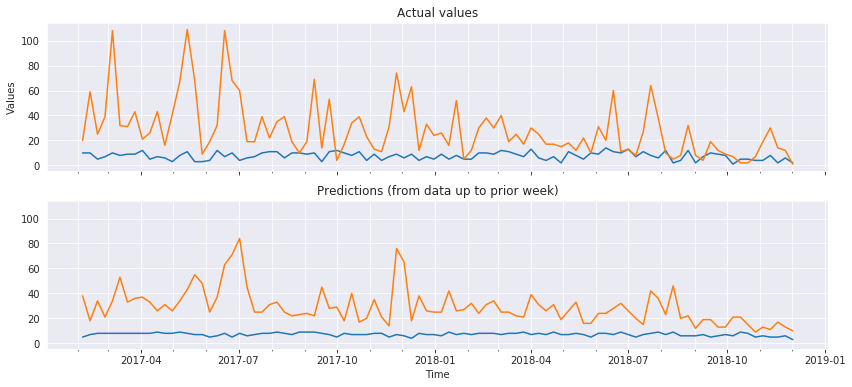

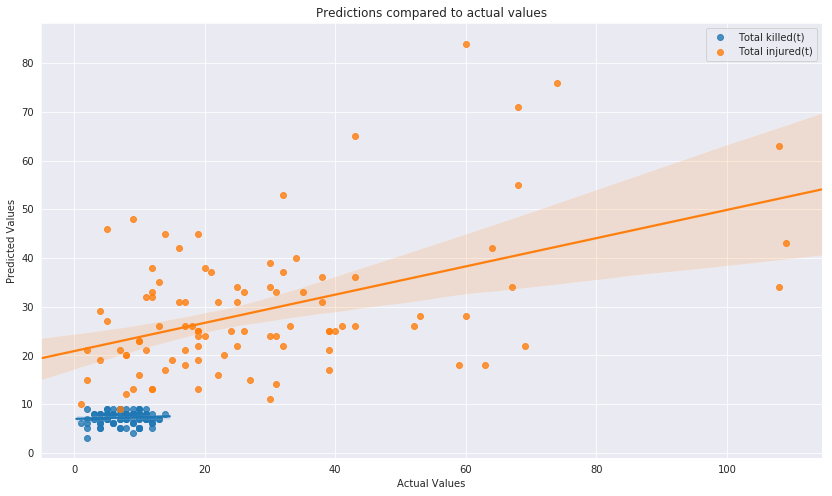

top score r_2: 0.200296619348
top score explained variance: 0.200541402306
best score rmse: 3.25800296705


In [44]:
#Train and test a given model

#import modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import check_cv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.dates as mdates

#create imputer for nan values - not currently used
imp = Imputer(missing_values='NaN', strategy = 'mean')


def plot_model(X_test, y_test, y_pred):
    '''Function to visualize what the model is doing to assist in evaluation'''
    
    months = mdates.MonthLocator()  # every month
    #put the predictions and desired values in a dataframe next to each other
    sync = pd.DataFrame(y_pred, index=y_test.index) #index=y_test.index)
    #print(sync.head())    
    
    #create subplots
    sns.set_style('darkgrid')
    
    f, ax = plt.subplots(2,1, figsize=(14,6), sharex=True)
    
    
    #plot the input values
    #ax[0].plot(X_test.sort_index())
    #ax[0].set_title('Test Input (previous weeks)')
    
    #plot the actual values
    ax[0].plot(y_test.sort_index())
    ax[0].set_title('Actual values')
    
    
    #plot the predictions
    ax[1].plot(sync.sort_index())
    ax[1].set_title("Predictions (from data up to prior week)")
    
  
    #show the plot
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].set_xlabel('Time')
    ax[0].set_ylabel('Values')
    ax[1].legend(bbox_to_anchor=(1,1))
    #locs, labels = plt.xticks()
    for x in range(2):
        ax[x].xaxis.set_minor_locator(months)
        ax[x].tick_params(which="both", bottom=True)
        ax[x].grid(which='minor')
    plt.show()
    
    #plot a comparison of the actual values next to the predictions - in a seperate figure
    f, ax = plt.subplots(figsize=(14,8))
    
    for var in range(y_test.shape[1]):
        sns.regplot(y_test.iloc[:,var], sync.iloc[:,var], ax=ax, label=y_test.columns[var])
    ax.set_title('Predictions compared to actual values')
    ax.set_ylabel('Predicted Values')
    ax.set_xlabel('Actual Values')
    
    if y_test.shape[1] < 15:
        ax.legend(bbox_to_anchor=(1,1))
    
    #show the plot
    plt.show()

def test_model(X_train, X_test, y_train, model):
    '''Function to make predicitons using the model based on training input'''
    #fit the model to the training set
    model.fit(X_train, y_train)

    #predict outcomes beased on training set
    y_pred = model.predict(X_test)
    
    #bandaid to set negative predictions to 0
    np.clip(y_pred, a_min=0, a_max=None, out=y_pred)
    
    return y_pred.astype(int, copy=False), model


def score_model(X_train, X_test, y_train, y_test, y_pred, model, verbose=False):
    '''fuction to score the model according to several metrics and return those metrics'''
    
    #score model
    #train_score = model.score(X_train, y_train)
    #test_score = model.score(X_test, y_test)
    r_2 = r2_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values') #
    ev = explained_variance_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test.astype(float), y_pred.astype(float), multioutput='raw_values'))
       
    #get array of coefiecents 
    coefs = np.empty((y_train.shape[1],X_train.shape[1]))
    try:
        for n in range(len(model.estimators_)):
            coefs[n] = model.estimators_[n].coef_  #you can get a list of feature names and coefs here in a loop and combine.
    except:
        try:    
            coefs = model.coef_#np.empty(y_pred.shape)
        except:
            try:
                print('unable to fetch coefs, trying importance...')
                coefs = model.feature_importances_
                
            except:
                print('Failed!')
    
    if verbose > 0:
        #Plot what these look like with fuction above
        plot_model(X_test, y_test, y_pred)
    
    #return train_score, test_score, r_2, ev, rmse, coefs, 
    return r_2, ev, rmse, coefs, 


def try_model(X, y, model, verbose=0, random_state=None):
    '''fuction to that takes a given model and a dataset, and evaluates the model
        -gives the option to plot relivant data
        -returns relivant scoring metrics'''

    #Split X and Y into training and testing sets < - try modifying these functions for 'sliding window'
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, shuffle=False, random_state=random_state)
    tscv = TimeSeriesSplit(n_splits=len(y)-1)
    
    
    #idx = 0
    y_pred = np.empty_like(y)
    for train_index, test_index in tscv.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        #use function above to train model and create predictions
        y_pred[test_index], model = test_model(X_train, X_test, y_train, model)
        if test_index.sum() < 0:
            print('\nRun:\t',test_index)
            print('X_train:\t', X_train.iloc[:,:2])
            print('y_train:\t', y_train.iloc[:,:2])
            print('X_test:\t', X_test.iloc[:,:2])
            print('y_pred:\t', y_pred[test_index])
            print('y_test:\t', y_test.iloc[:,:2])
        
        #idx += 1
        
    
    #use function above to score the model based on predictions - PREDICTIONS ARE TOO GOOD NOW, MUST BE ERROR
    #train_score, test_score, r_2, ev, rmse, coefs  = score_model(X_train, X_test, y_train, y_test, y_pred, model, verbose=verbose)
    r_2, ev, rmse, coefs  = score_model(X_train[5:], X[5:], y_train[5:], y[5:], y_pred[5:], model, verbose=verbose)
    
    if verbose > 0:
        #print scores
        #print('total train score:', train_score )
        #print('total test score:', test_score)
        print('top score r_2:',r_2.max())
        print('top score explained variance:',ev.max())
        print('best score rmse:',rmse.min())
        
        #legacy code 
        #print('confusion matrix\n',cm)#n,p\nn', cm[0],'\np',cm[1])
        #if cv_done == True:
        #    print('crossvalidation mean:',cv_score.mean(), cv_score)
        #else:
        #    print('Initial test score not promissing. No crossvalidation')
        #print('Top Feature Probabilities:', log_proba.sort_values(1, axis=1, ascending=False))
        #print('Bottom Feature Probabilities:', bottom_prob)
       
    #return train_score, test_score, r_2, ev, rmse, coefs
    return r_2, ev, rmse, coefs

    
#define y
y = y_week.loc[:,['Total killed(t)','Total injured(t)']] # > in_week.loc[:,'Total killed'].quantile(.5)      

#print('Full Dataset:')
#Plot what X and y look like
#sns.set_palette(catpal)
#sns.set_style('darkgrid')
#f, (ax1, ax2) = plt.subplots(2,1, figsize=(16,4))
#f.tight_layout(h_pad=2)


#ax1.plot(X_week)
#ax1.set_title('X - All variables, 1-{} weeks less than y'.format(int(lookback)))
#ax2.plot(y)
#ax2.set_title('y - variables to be predicted')
#f.suptitle('Full Dataset Visualization', fontsize='x-large')
#plt.show()

print('Dry Run:')
#give the function to try a given model a dry run to see if it works.
dry_run = try_model(X_week, y, RandomForestRegressor(random_state=56), verbose = 2, random_state=56)


The visualization above is the output of a "dry run" of one model, with a prediction of two variables to ensure the core functions are working correctly.

### Find variables with the best prediction scores

All Variables
unable to fetch coefs, trying importance...


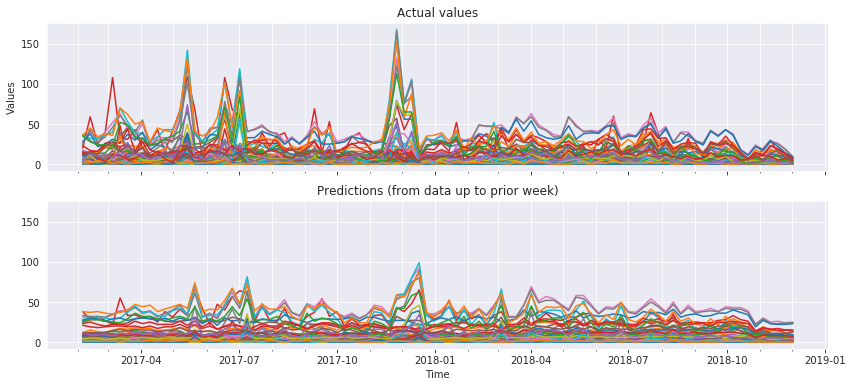

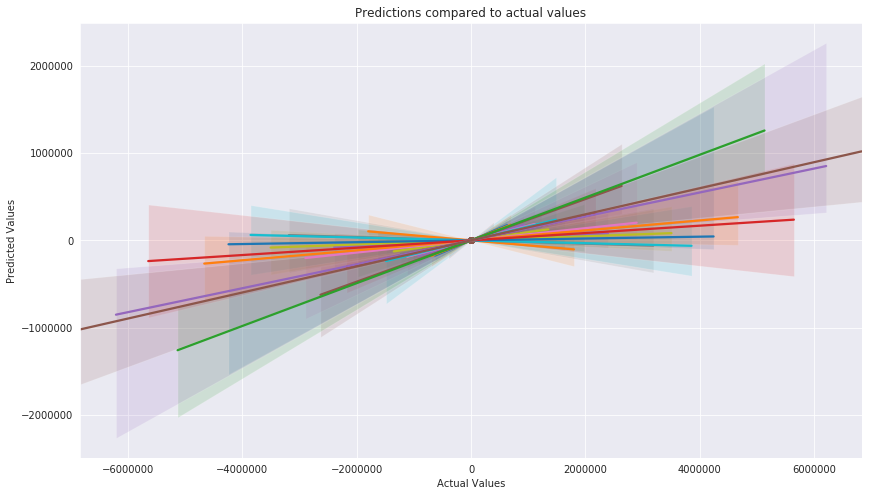

top score r_2: 0.339318002597
top score explained variance: 0.348526003043
best score rmse: 0.456435464588

Top Scoring Variable:
unable to fetch coefs, trying importance...


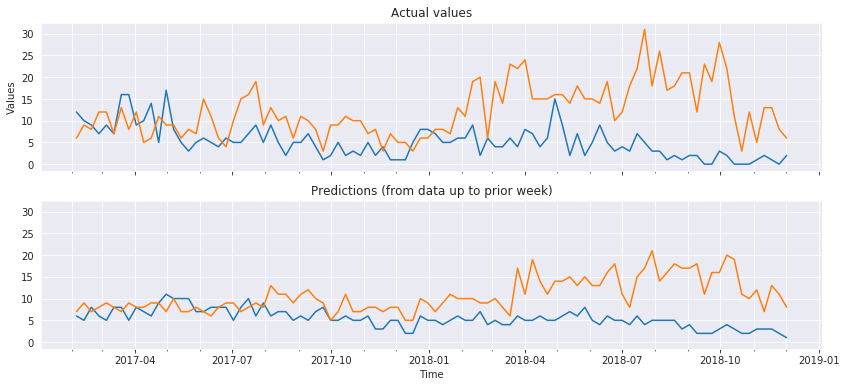

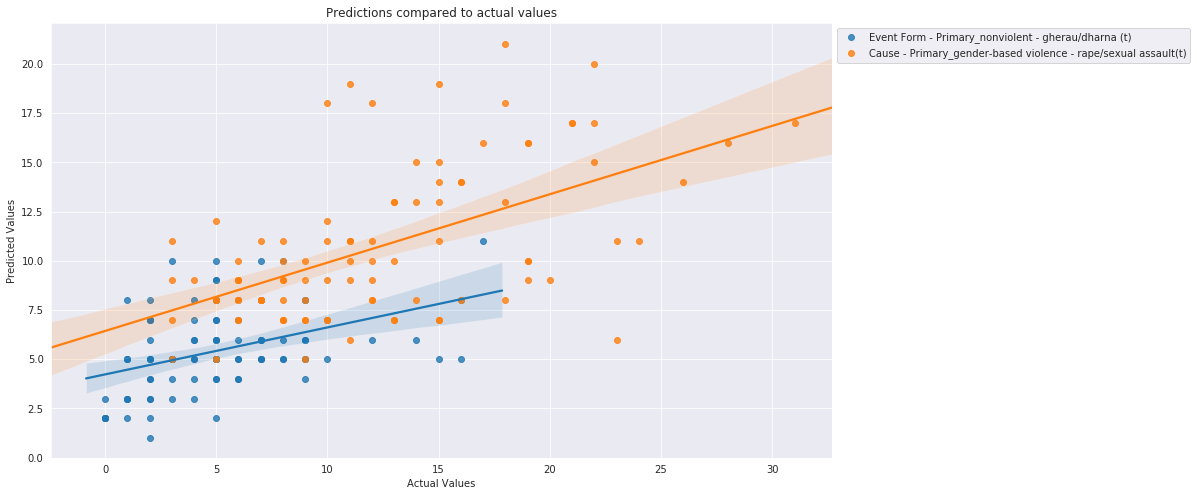

top score r_2: 0.232613908873
top score explained variance: 0.301269764857
best score rmse: 3.40036762718


,r_2,explained_variance,root_mean_squared_error
Event Form - Primary_nonviolent - gherau/dharna (t),0.339318,0.348526,3
Cause - Primary_gender-based violence - rape/sexual assault(t),0.230046,0.310948,5.30232
Event Form - Primary_violent - sexual assault(t),0.232329,0.310703,5.21616
Violent / Nonviolent_nonviolent(t),0.27431,0.299862,9.54812
Total raped(t),0.156174,0.262098,5.38033
Female raped(t),0.142764,0.243362,5.23012
Actor 1 - Youth/non-youth_unknown(t),0.172305,0.187936,21.8303
Actor 1 - Youth/non-youth_noyouth(t),0.117074,0.172336,4.41352
Actor 2 - Youth/non-youth_na(t),0.152856,0.164199,16.8334
Youth raped(t),0.0430722,0.149467,4.8734


In [45]:
#find which variables have the best scores
from sklearn.linear_model import ARDRegression

def find_var (X, df, model, n_true, verbose=False, random_state=None):
    scores = pd.DataFrame(index=df.columns, columns=['r_2','explained_variance','root_mean_squared_error'])
    #for var in df.columns:
    #y = df# > df[var].quantile(.5)
    #X = time_shift.loc[:,'var1(t-1)':'var340(t-1)']
    #n_class = y.nunique()
    #n_bins = 10
    #n_true = 10
    
    pc_true = [sum(df[x] >= 1)/len(df[x])*100 > n_true for x in df.columns]
    #flt = 
    y = df.loc[:,pc_true] #filter out varables the perentage "true" is less than n_true
        #if verbose == True:
         #   print('\n')
          #  print(var)
        #if verbose == False:
         #       print('.', end='')
        
      
    r_2, ev, rmse, coefs = try_model(X, y, model, verbose = verbose, random_state=random_state)
            
     #scores.loc[var,'cv_mean'] = cv_score.mean()
    #scores.loc[:,'train_score'] = train_score
    #scores.loc[:,'test_score'] = test_score
    #scores.loc['pc_true'] = pc_true   
    scores.loc[pc_true,'r_2'] = r_2
    scores.loc[pc_true,'explained_variance'] = ev
    scores.loc[pc_true,'root_mean_squared_error'] = rmse
            #scores.loc[var,'confusion_matrix'] = cm
            #print(scores[var])
    
    #print('bing!')
    
    return scores

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)
#for step in range(5,y_week.shape[1])[::5]:
    #model = MultiOutputRegressor(ARDRegression(), n_jobs=-1)
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    #model = LinearRegression()
    model = RandomForestRegressor(random_state=56)
    
    
    print("All Variables")
    scores = find_var(X_week, y_week, model, n_true=20, verbose=2, random_state=38)
    top = scores.loc[scores['explained_variance'] > .1].sort_values('explained_variance', ascending=False)
    
    print("\nTop Scoring Variable:")
    top_score = find_var(X_week, y_week.loc[:,top.index[:2]], model, n_true=20, verbose=2, random_state=38)
top

### Comparatively Evaluate Predictive Models

In [43]:
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import TheilSenRegressor



def search_models(modellist, catlist, verbose=False, random_state=False):
    categories = y_week.columns.tolist()
    scoresdf = pd.DataFrame(index=categories)
    warnings.filterwarnings("ignore")
    for model in modellist:
        #par = model.get_params
        modelstring = str(model)[:13]
        print('\n{}:'.format(modelstring))
        try:
            print('Trying Native Multioutput...')
            model_scoresdf = find_var(X_week, y_week[catlist], model, n_true=10, verbose=verbose, random_state=random_state)
        except:
            print('Failed... Using MultiOutput wrapper')
            model_scoresdf = find_var(X_week, y_week[catlist], MultiOutputRegressor(model, n_jobs=-1), n_true=10, verbose=verbose, random_state=random_state)
        
        print('Top 3 scores:\n',model_scoresdf['explained_variance'].sort_values(ascending=False)[:3])
        
        
        
        scoresdf = scoresdf.join(model_scoresdf, how='left', sort=False, rsuffix=('_'+modelstring))
        #top5 = scoresdf.sort_values(scoresdf.columns.tolist(), axis=0, ascending=False)[:5]
        #top5_col = top5.sort_values(top5.index.tolist(), axis=1, ascending=False).iloc[:,:1]
        #print(top5_col)
        
        #label first section of df < debug later
        if scoresdf.shape[1] == 3:
            new_cols = scoresdf.columns.tolist()
            for x in range(3):
                new_cols[x] = new_cols[x] + '_' + modelstring
            scoresdf.columns = new_cols
            print('appended', modelstring, 'to first column name')
    
    print('Bing!')
    return scoresdf
random_state=56
if __name__ == '__main__': #protect windows from parallel processes(if you run windows)
    modellist=[RandomForestRegressor(random_state=random_state),
               #ARDRegression(),
               BayesianRidge(),
               ElasticNet(random_state=random_state),
               #ElasticNetCV(random_state=random_state), < save automatic Cv for holdout sets
               HuberRegressor(),
               #Lars(random_state=random_state), < tiny results
               Lasso(random_state=random_state),
               LinearRegression(),
               #MultiTaskLassoCV(random_state=random_state),<way too slow
               PassiveAggressiveRegressor(random_state=random_state),
               #Perceptron(random_state=random_state),
               TheilSenRegressor(random_state=random_state)]
               #RidgeCV()]

    scoresdf = search_models(modellist, top.index, random_state=random_state)
    scoresdf.head()


RandomForestR:
Trying Native Multioutput...
unable to fetch coefs, trying importance...
Top 3 scores:
 Event Form - Primary_violent - sexual assault(t)                  0.316682
Cause - Primary_gender-based violence - rape/sexual assault(t)    0.316675
Total raped(t)                                                     0.26064
Name: explained_variance, dtype: object
appended RandomForestR to first column name

BayesianRidge:
Trying Native Multioutput...
Failed... Using MultiOutput wrapper
Top 3 scores:
 Event Form - Primary_violent - sexual assault(t)                  0.282697
Cause - Primary_gender-based violence - rape/sexual assault(t)    0.274433
Actor 2 - Youth/non-youth_na(t)                                    0.19736
Name: explained_variance, dtype: object

ElasticNet(al:
Trying Native Multioutput...
Failed... Using MultiOutput wrapper


Process ForkPoolWorker-13265:
  File "/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py", line 477, in enet_path
    positive)
Process ForkPoolWorker-13272:
Process ForkPoolWorker-13266:
Process ForkPoolWorker-13271:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "<ipython-input-43-ca38f4f7c7d7>", line 31, in search_models
    model_scoresdf = find_var(X_week, y_week[catlist], model, n_true=10, verbose=verbose, random_state=random_state)
  File "<ipython-input-43-ca38f4f7c7d7>", line 31, in search_models
    model_scoresdf = find_var(X_week, y_week[catlist], model, n_true=10, verbose=verbose, random_state=random_state)
  File "<ipython-input-43-ca38f4f7c7d7>", line 31, in search_models
    model_scoresdf = find_var(X_week, y_week[catlist], model, n_true=10, verbose=verbose, random_state=random_state)
  File "<ipython-input-42-19edf3dc5c8d>", 

  File "/home/nhorning/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py", line 752, in fit
    check_input=False)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/nhorning/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):

During handling of the above exception, another exception occurred:

KeyboardInterrupt
  File "/home/nhorning/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/hom

KeyboardInterrupt: 

KeyboardInterrupt
  File "/home/nhorning/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt


In [13]:
scoresdf.head()

,r_2_RandomForestR,explained_variance_RandomForestR,root_mean_squared_error_RandomForestR,r_2,explained_variance,root_mean_squared_error,r_2_ElasticNet(al,explained_variance_ElasticNet(al,root_mean_squared_error_ElasticNet(al,r_2_HuberRegresso,...,root_mean_squared_error_Lasso(alpha=1,r_2_LinearRegress,explained_variance_LinearRegress,root_mean_squared_error_LinearRegress,r_2_PassiveAggres,explained_variance_PassiveAggres,root_mean_squared_error_PassiveAggres,r_2_TheilSenRegre,explained_variance_TheilSenRegre,root_mean_squared_error_TheilSenRegre
Total killed(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Female killed(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Youth killed(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total injured(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Female injured(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


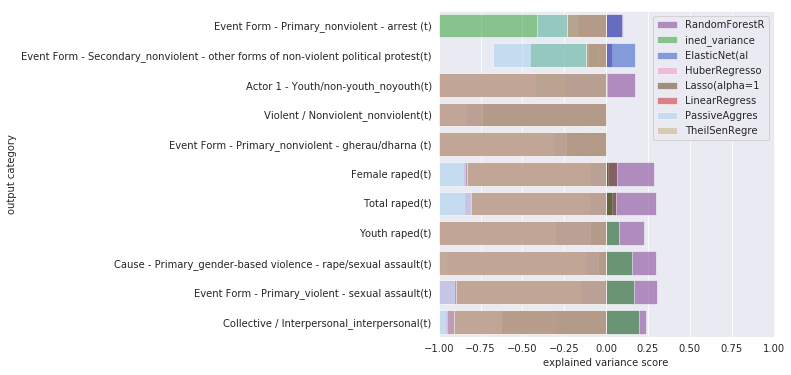

,explained_variance_RandomForestR,explained_variance,explained_variance_ElasticNet(al,explained_variance_HuberRegresso,explained_variance_Lasso(alpha=1,explained_variance_LinearRegress,explained_variance_PassiveAggres,explained_variance_TheilSenRegre
Event Form - Primary_nonviolent - arrest (t),0.0982487,-3.26925e+34,0.0966017,-0.175833,-0.171309,-0.231666,-0.415416,-0.231666
Event Form - Secondary_nonviolent - other forms of non-violent political protest(t),0.0327294,-0.456129,0.174633,-0.0442896,-0.107846,-0.122243,-0.6731,-0.122046
Actor 1 - Youth/non-youth_noyouth(t),0.172723,-0.425652,-0.254181,-1.40624,0.00326241,-1.11853,-1.62833,-1.11143
Violent / Nonviolent_nonviolent(t),-0.0786035,-0.139906,-0.837349,-1.42761,-0.741476,-2.16666,-9.10317,-2.17291
Event Form - Primary_nonviolent - gherau/dharna (t),-0.194222,-0.118746,-0.314813,-1.19828,-0.241149,-1.23156,-2.21567,-1.23405


In [14]:
#top_scores_df = scoresdf.sort_values(scoresdf.columns.tolist(), axis=0, ascending=False).iloc[:10,:]
#top_scores_df.dropna(inplace=True)

#Plot explained variance of scores of various regressors
colr=0
expv = scoresdf.iloc[:,1::3].dropna()
expv = expv.sort_values(expv.columns[1])
f, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_xlim(-1,1)
for col in expv.columns:
    #plot = expv.loc[expv[col] > 0]
    if len(expv) > 0:
        sns.barplot(x=col, y=expv.index, data=expv, color=catpal[colr], label=col[-13:], alpha=0.5, ax=ax, dodge=True)
    colr+=1
#sns.barplot(y=expv.index, data=expv, alpha=0.5, ax=ax)    
plt.xlabel('explained variance score')
plt.ylabel('output category')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
        
#for col in scoresdf.columns[2::3]:
    #plot = scoresdf[[col]].sort_values(col).loc[scoresdf[col] < .3]
    #if len(plot) > 0:
        #sns.barplot(x=col, y=plot.index, data=plot)
        #plt.show()
expv.head()

In [15]:
def interpret_coefs(coefs, X_train, cats):
    '''plot histograms of the coefficients as well and bar charts of the top coefficients'''
    
    #plot histogram of coefficents for each out variable  
    for cat in range(len(cats)):
        try:
            sns.distplot(coefs[cat], color=catpal[cat], label=cats[cat])#.sort_values(1))
        except:
            print("couldn't plot ", cats[cat])
    
    #plot top coefficnts for each variable - currently doesn't do it, plotting top for one. 
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    #creat a dataframe of coefiecents and their feature labels by output
    try:
        coefframe = pd.DataFrame(coefs, index=cats, columns=X_train.columns)
    except:
        coefframe = pd.Series(coefs, index=X_train.columns)
    coefframe = coefframe.transpose()
    
    try:
        serieslist = []
        for cat in coefframe.columns:
            serieslist.append(coefframe.loc[:,cat].nlargest(5))
            data = concat(serieslist, axis=1)
    except:
        data=coefframe.nlargest(5)
    for n in range(len(cats)):
        cat = cats[n]
        sns.swarmplot(y=data.index, x=cat, data=data, color=catpal[n], orient='h', alpha=.5)
        
        #plt.legend()
    plt.ylabel('input category')
    plt.xlabel('coef')
    plt.legend()
    plt.show()
    #except:
     #   print("Couldn't plot the top coefs for reasons")

def investigate(cats, X_train, y_train, holdout_X, holdout_y, model, verbose=0, random_state=None):
    '''function to look futher into better performing results'''
    holdout_scores = pd.DataFrame(index=cats, columns=['r_2', 'explained_variance','root_mean_squared_error'])
    #for cat in cats:
    y = y_train[cats]# > y_train[cat].quantile(.5)
    if verbose > 0:
        #print('\n',y_train[cats].columns,':')
        r_2, ev, rmse, coefs = try_model(X_train, y, model, verbose = 2, random_state=random_state)
        interpret_coefs(coefs,X_train,cats)
    
    h_y = holdout_y[cats]# > holdout_y[cat].quantile(.5)
    y_pred, model = test_model(X_train, holdout_X, y, model)
    train_score, test_score, r_2, ev, rmse, coefs = score_model(X_train, holdout_X, y, h_y, y_pred, model)
    if verbose > 0:
        plot_model(holdout_X, h_y, y_pred)
        interpret_coefs(coefs, holdout_X, cats)
        #scores = score_model(X_train, holdout_X, y, h_y, y_pred, model)
        #holdout_scores.loc[cat,['train_score', 'test_score', 'confusion_matrix', 'r_2']] = scores
        #holdout_scores.loc[cat,'train_score'] = train_score
        #holdout_scores.loc[cat,'test_score'] = test_score
        #holdout_scores.loc[cat,'confusion_matrix'] = cm
    holdout_scores.loc[cats,'r_2'] = r_2
    holdout_scores.loc[cats,'explained_variance'] = ev
    holdout_scores.loc[cats,'root_mean_squared_error'] = rmse
    return holdout_scores


In [16]:
tops = scoresdf['explained_variance_RandomForestR'].sort_values(ascending=False)[:5]
tops

Event Form - Primary_violent - sexual assault(t)                  0.301276
Cause - Primary_gender-based violence - rape/sexual assault(t)    0.300597
Total raped(t)                                                    0.297622
Female raped(t)                                                   0.283195
Collective / Interpersonal_interpersonal(t)                       0.240169
Name: explained_variance_RandomForestR, dtype: object

unable to fetch coefs, trying importance...


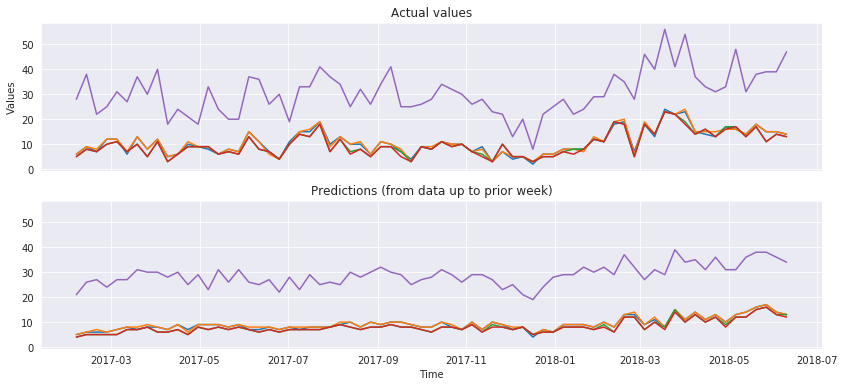

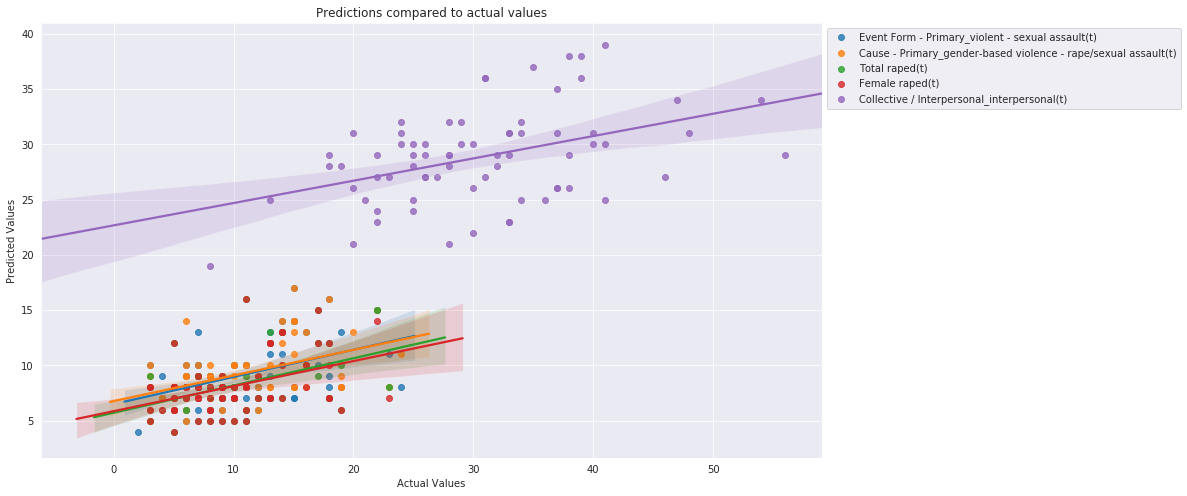

top score r_2: 0.141491062125
top score explained variance: 0.207503211991
best score rmse: 4.57026519402
couldn't plot  Event Form - Primary_violent - sexual assault(t)
couldn't plot  Cause - Primary_gender-based violence - rape/sexual assault(t)
couldn't plot  Total raped(t)
couldn't plot  Female raped(t)
couldn't plot  Collective / Interpersonal_interpersonal(t)


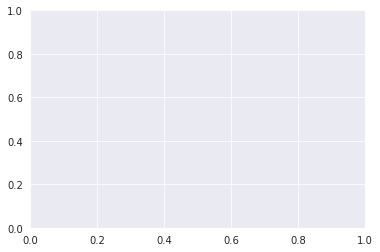

ValueError: Could not interpret input 'Event Form - Primary_violent - sexual assault(t)'

In [17]:
if __name__ == '__main__': #protect windows from parallel processes(if you run windows)            
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    model = RandomForestRegressor()
    holdout = investigate(tops.index, X_week, y_week, holdout_X_week, holdout_y_week, model, verbose=True, random_state=38)
holdout.sort_values('explained_variance', ascending=False)

In [ ]:
#create function to optimize lookback!
import random
from sklearn.linear_model import MultiTaskElasticNetCV

def opt_lookback(df, model):
    '''function to optimize number of units to look back through time'''
    print('Optimizing...')
    scorelist = []
    categories = df.columns.tolist()
    scoredf = pd.DataFrame(index=categories)#need to
    
    #generate a random state for consistent comparisons
    random_state = random.randint(1,1000)
    print('using random_state:', random_state)
    #loop through possible ranges to look back at to find the the optimum value
   
    for lookback in (range(1,50)):
        
        #create a timeshifted dataframe within that range
        time_shift = make_timeshift(df, lookback)
        
        #split timeshift into training and hold out data sets
        X, y, holdout_X, holdout_y = create_X_y(time_shift)
        
        #bandaid fix
        scoredf.index = y.columns.tolist()
        
        #find the scores for all the variables #(those which have more positives than negatives)
        scores = find_var(X, y, model, n_true=50, verbose=0, random_state=random_state)
        
        #print(scores.head())
        #find the sum of the crossvalidation scores
        #test = np.sum(scores['cv_mean'])
        
        
        #find which variables recieved a score above 0
        top_scores = scores.loc[scores['explained_variance'] > 0].index.tolist()
        #print(top_scores)
        
        #find sum of scores above 0
        top_sum = np.sum(scores.loc[top_scores,'explained_variance'])
        
        #use investigate function to see how those variables did against the holdout set
        holdout_scores = investigate(top_scores, X, y, holdout_X, holdout_y, model, verbose=False, random_state=random_state)             
        #print(holdout_scores.head())
        
        #find the sum of the hold out test scores scores
        holdout_max = np.max(holdout_scores.loc[:,'explained_variance'])
        #print(holdout_sum)
        
        #print the lookback interval, and mean scores
        print('\nt-{0} top sum: {1:.2f}, holdout_max: {2:.2f} '.format(lookback,top_sum, holdout_max))
        
        #append the crossvalidation score to the list
        scorelist.append(top_sum)#(cv_score)
        
        #join the scores to the data frame of scores
        scoredf = scoredf.join(scores, how='left', sort=False, rsuffix=('(t-'+str(lookback).zfill(3)+')'))
        scoredf = scoredf.join(holdout_scores, how='left', sort=False, rsuffix='_holdout(t-'+str(lookback).zfill(3)+')')
        #scoredf = pd.concat([scoredf, scores, holdout_scores], axis=1, join_axes=[scoredf.index])
        
        #stop fuction and return scores soon as there is a definate downward trend
        if len(scorelist) > 5:
            if np.median(scorelist[-2:]) < np.median(scorelist[-5:-2]):
                return scoredf

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)            
    
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    #scoredf_day = opt_lookback(in_day, model)
    scoredf_week = opt_lookback(in_week, model)
    print('bing!')

    scoredf_week.head()
    #plt.plot(scoredf_day)#, label = 'by day')
    #plt.plot(scoredf_week, label = 'by week')
    #plt.title('Mean crossvalidation scores v. lookback times')
    #plt.legend()
    #plt.show()

In [ ]:
scoredf_week
#scoredf_week['cv_mean'].sum()
#scoredf_week.iloc[:,::4]

In [ ]:
def plot_frame(df, start):
    plotframe = df.iloc[:,start::6]#.sort_values(df.columns[start::4].tolist(), axis=0, ascending=False)[:10]
    meanlist = pd.Series([plotframe.loc[x,:].mean() for x in plotframe.index], index=plotframe.index)
    plotvar = plotframe.loc[meanlist.sort_values(ascending=False)[:10].index]
    #sortvar = plotvar.sort_index(axis=1, ascending=False)
    for label in plotvar.index:
        plt.plot(plotvar.loc[label,:], label=label)

    plt.xticks(rotation=90)
    plt.ylim(-1,1)
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Top 10 '+plotvar.columns[0])
    plt.show()
    #print(plotvar)

#print('day')
#for start in [0,1,3,5,7]:
    #plot_frame(scoredf_day, start)

print('week')
for start in [0,1,2,3]:
    plot_frame(scoredf_week, start)
    


In [ ]:
scoredf_week.sort_values('test_score_holdout(t-009)', ascending=False)

In [ ]:
#plt.plot(scorelist_day, label = 'by day')
#plt.plot(scorelist_week, label = 'by week')
#plt.title('Mean crossvalidation scores v. lookback times')
#plt.legend()
#plt.show()
#scoredf_day
#plt.plot()

#plt.show()
#scoredf_day.loc[:,::4]
plt.plot(scoredf_day.iloc[:,0::7].sort_values('cv_mean(t-3)')[:10], marker='.', linestyle='none')
plt.xticks(rotation=90)
plt.show()

Note effectiveness of MultinomialNB() at predicting demonstrations and sit ins / collective violence based on indicators from the previous weeks. Indicators that ... and testing on the hold out set of this years data.

Perhaps proceed with dialing in collective violence. 

In [ ]:
#Dial in communal violence predictions


In [ ]:
cv_scores_day = find_var(X_day, in_day, MultinomialNB(), n_true=20, verbose=False)
top10_day = cv_scores_day.sort_values('cv_mean', ascending=False)[:10]
top10_day

In [ ]:
for cat in top10_day.index:
    print('\n',cat)
    y = in_day[cat] > 1
    cv_score, test_score, cm, log_proba = try_model(X_day, y, MultinomialNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X_day, y, MultinomialNB(), verbose = 2)
        interpet_prob(log_proba)

In [ ]:
from sklearn.naive_bayes import BernoulliNB

BNB_scores = find_var(X, in_week, BernoulliNB(), n_true=20, verbose=False)
BNB_top10 = BNB_scores.sort_values('cv_mean', ascending=False)[:10]
BNB_top10

scoreBNBdf_week = opt_lookback(in_week, MultinomialNB())

In [ ]:
scoreBNBdf_week = opt_lookback(in_week, MultinomialNB())

In [ ]:
for cat in BNB_top10.index[:5]:
    print('\n',cat)
    y = in_week[cat] > in_week[cat].quantile(.75)
    cv_score, test_score, cm, log_proba = try_model(X, y, BernoulliNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, BernoulliNB(), verbose = 2)
        interpet_prob(log_proba)

In [ ]:
for cat in BNB_top10.index[:5]:
    print('\n',cat)
    y = in_day[cat] > 1
    cv_score, test_score, cm, log_proba = try_model(X_day, y, BernoulliNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, BernoulliNB(), verbose = 2)
        interpet_prob(log_proba)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
rgs = RandomForestRegressor()
cls = RandomForestClassifier()
#y = 
#try_model(X, y, cls)

In [65]:
clsdf_week = opt_lookback(in_week, rgs)

Optimizing...
.

AttributeError: 'RandomForestRegressor' object has no attribute 'predict_log_proba'

In [ ]:
top6 = cv_scores.sort_values('cv_mean', ascending=False)[:6]
top6

In [ ]:
s2 = pd.Series([6,8,3], index=list('abc'))
s4 = pd.Series([1,2,3], index=list('abc'))

s2 + s4